This notebook allows for attention visualization by means of rollout. It is described in https://arxiv.org/abs/2005.00928

Code source: https://medium.com/@nivonl/exploring-visual-attention-in-transformer-models-ab538c06083a

In [1]:

import numpy as np
from PIL import Image, ImageFilter
import torch
import matplotlib.pyplot as plt
from torchvision import datasets 

torch.cuda.is_available()
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [3]:


from transformers import ViTForImageClassification, ViTImageProcessor, AutoImageProcessor

# Load a ViT model and feature extractor
model = ViTForImageClassification.from_pretrained("./vit-base-output-alt-448")
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k', attn_implementation='eager')

image_path = 'TESTDATA/myown.jpg'
image = Image.open(image_path)
# Run an image through the pipline
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Getting the attentions
attentions = outputs.attentions 


c:\Users\Menee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<class 'torch.Tensor'>
tensor([[0.3219, 0.2836, 0.2263, 0.2557, 0.2981, 0.2086, 0.3354, 0.3399, 0.5013,
         0.2182, 0.1886, 0.4153, 0.3120, 0.1282],
        [0.4078, 0.5282, 0.4145, 0.7094, 0.4527, 0.3839, 0.3994, 0.4964, 0.3600,
         0.5206, 0.4386, 0.3240, 0.3691, 0.3240],
        [0.5554, 0.4180, 0.4791, 0.6540, 0.4622, 0.6309, 0.5206, 0.6460, 0.5245,
         0.5526, 0.4920, 0.7121, 0.7856, 0.3817],
        [0.4211, 0.3618, 0.3719, 0.4320, 0.6838, 0.7616, 0.6214, 0.6092, 0.6574,
         0.5418, 0.6107, 0.7132, 0.6292, 0.6029],
        [0.3544, 0.6249, 0.6370, 0.6533, 0.7608, 0.6454, 0.4258, 0.9427, 0.5680,
         0.6104, 0.7377, 0.6796, 0.5456, 0.3154],
        [0.6196, 0.8174, 0.5889, 0.5860, 0.6858, 0.5581, 0.9326, 0.9574, 0.9974,
         0.6049, 0.6505, 0.6197, 0.8712, 0.4459],
        [0.5252, 0.7178, 0.6111, 0.6023, 0.8088, 0.8955, 0.8831, 0.9548, 0.8695,
         0.9009, 0.5634, 0.5659, 0.6063, 0.3213],
        [0.2252, 0.6628, 0.4663, 0.5337, 0.6067, 0.9632, 0.8

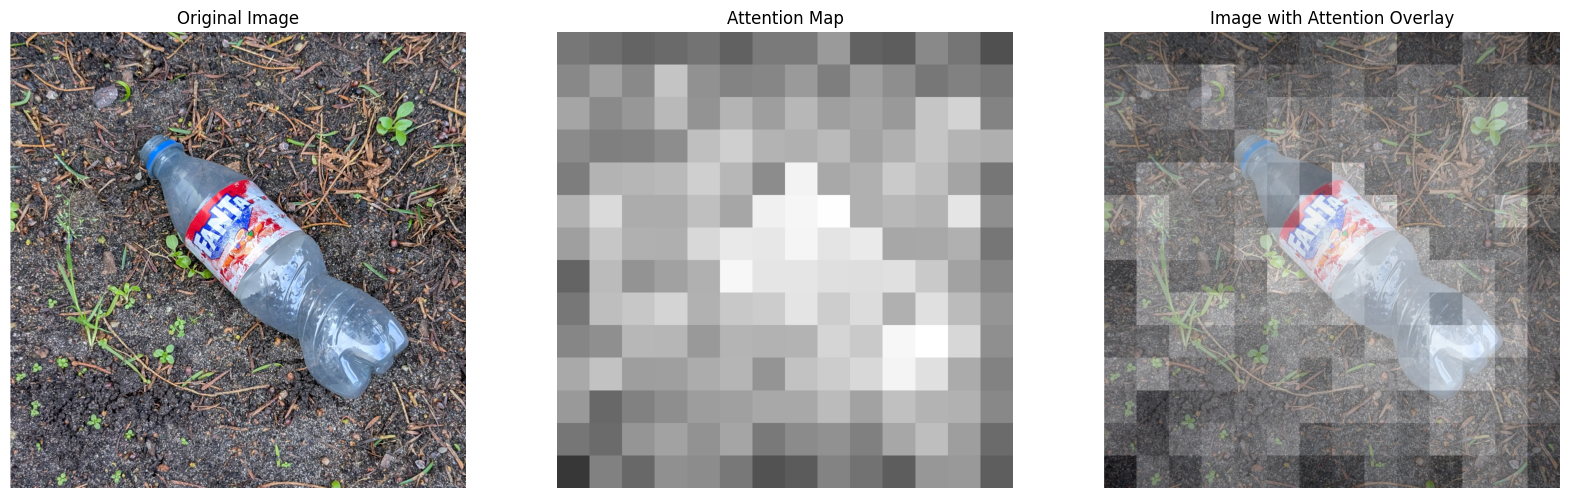

In [4]:
rollout = attention_rollout(attentions)
print(type(rollout))

cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(int(14), int(14))

# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
print(cls_attention)
# Resize and blur the attention map
cls_attention_resized = Image.fromarray((cls_attention * 255).detach().numpy().astype(np.uint8)).resize((1080, 1080), resample=Image.NEAREST)
cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(200)  # Adjust alpha for blending (lower value for darker overlay)

# Plot the original image and the image with cls_attention_colored_img overlapped
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(cls_attention_colored_img)
ax[1].set_title('Attention Map')
ax[1].axis('off')

# Image with attention overlay
ax[2].imshow(image, cmap='gray')
ax[2].imshow(cls_attention_colored_img, alpha=0.8)
ax[2].set_title('Image with Attention Overlay')
ax[2].axis('off')

plt.show()